# Harmonic comparison
Demonstrate the numerical method for getting power spectra from calculated fields, rather than closed numerical solutions.

Author: S. Jones

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc
from CRESSignalStructure.QTNMTraps import HarmonicTrap
from CRESSignalStructure.Particle import Particle
from CRESSignalStructure.BaseField import BaseField
from CRESSignalStructure.RealFields import HarmonicField
from scipy.optimize import minimize

In [2]:
# Allow LaTeX in figures
plt.rcParams['text.usetex'] = True

## Fitting to a real field

Plot a sample harmonic field and fit a quadratic function to it. 
This will allow us to extract some sample parameters.
Recall that the harmonic trap field is given by
$$
B(z) = B_0 \left(1 + \frac{z^2}{L_0^2} \right) \, .
$$

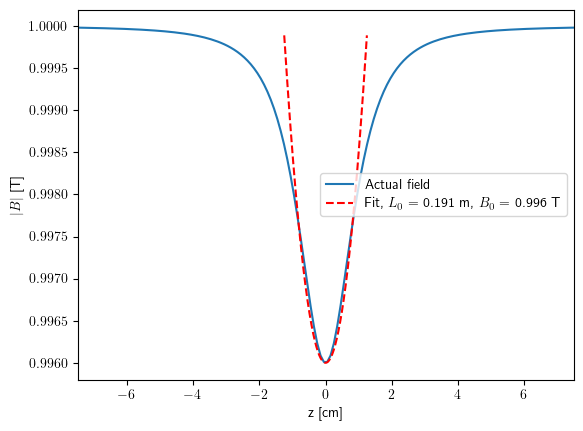

In [3]:
trapDepth = 4e-3  # Tesla
rCoil = 1.25e-2     # metres
iCoil = 2 * trapDepth * rCoil / sc.mu_0
bkgField = 1.0
hField = HarmonicField(rCoil, iCoil, bkgField)

zPlotArr = np.linspace(-0.1, 0.1, 200)
bPlotArr = hField.evaluate_field_magnitude(0.0, 0.0, zPlotArr)

# Create shorter range for fitting
modFitRange = 0.75e-2
z_data = np.linspace(-modFitRange, modFitRange, 100)
B_data = hField.evaluate_field_magnitude(0.0, 0.0, z_data)

def harmonic_form(z, params):
    """
    Function for harmonic form of trap

    Parameters
    ----------
    z
    """
    z = np.asarray(z)
    L0, B0 = params

    result = B0 * (1.0 + z**2 / L0**2)
    return result

def fit_harmonic_form(z_data, B_data, initial_params):
    z_min, z_max = np.min(z_data), np.max(z_data)

    def objective(params):
        L0, B0 = params

        if L0 <= 0.0:
            return 1e6
        if B0 <= 0.0:
            return 1e6

        B_pred = harmonic_form(z_data, params)
        return np.sum((B_data - B_pred)**2)

    result = minimize(objective, initial_params, method='Nelder-Mead',
                      options={'maxiter': 100000, 'xatol': 1e-8})
    
    if not result.success:
        print(f"Warning: Optimisation did not converge. Message: {result.message}")

    fitted_params = result.x
    z_fit = np.linspace(z_min, z_max, 1000)
    B_fit = harmonic_form(z_fit, fitted_params)
    return fitted_params, z_fit, B_fit

test_params = np.array([20e-2, bkgField - trapDepth])
fitted_params, z_fit, B_fit = fit_harmonic_form(z_data, B_data, test_params)
L0_fit = fitted_params[0]
B0_fit = fitted_params[1]

fig, ax = plt.subplots(1, 1)
ax.plot(zPlotArr * 1e2, bPlotArr, label='Actual field')
z_plot = np.linspace(-1.25e-2,1.25e-2, 1000)
ax.plot(z_plot * 1e2, harmonic_form(z_plot, test_params), 'r--',
        label=fr'Fit, $L_0 =$ {L0_fit:.3f} m, $B_0 =$ {B0_fit:.3f} T')
ax.set_xlabel('z [cm]')
ax.set_ylabel(r'$|B|$ [T]')
ax.set_xlim(-7.5, 7.5)
ax.legend()

## Numerically calculating motion

### Calculating $z_\text{max}$ and $\Omega_a$

Compare the numerically calculated axial frequencies with those from an analytical trap with the same parameters.
Recall that we can find $z_\text{max}$ by using the conserved nature of the magnetic moment
$$
\mu(t) = \frac{1}{2} \frac{p_0^2}{m_e} \frac{\sin^2 \theta(t)}{B(t)}
$$
and solving the equation
$$
1 - \frac{\mu_\text{centre}}{B(z_\text{max})} = 0
$$
for $z_\text{max}$.

For symmetric traps, the axial frequency can be found via the equation
$$
\Omega_a^{-1} =  \frac{2}{\pi} \int_0^{z_\text{max}} \frac{dz}{\sqrt{\frac{2}{m} (E_0 - \mu B(z)) }} \, .
$$

In [4]:
from CRESSignalStructure.NumericalSpectrumCalculator import calc_zmax, calc_omega_axial

zmax = calc_zmax(hField, Particle(18.6e3, np.zeros(3), 88.5 * np.pi / 180))
oa = calc_omega_axial(hField, Particle(18.6e3, np.zeros(3), 88.5 * np.pi / 180))
print(f"Axial frequency = {oa / (2 * np.pi) / 1e6:.1f} MHz, z_max = {zmax * 1e2:.1f} cm")

Axial frequency = 72.5 MHz, z_max = 0.5 cm


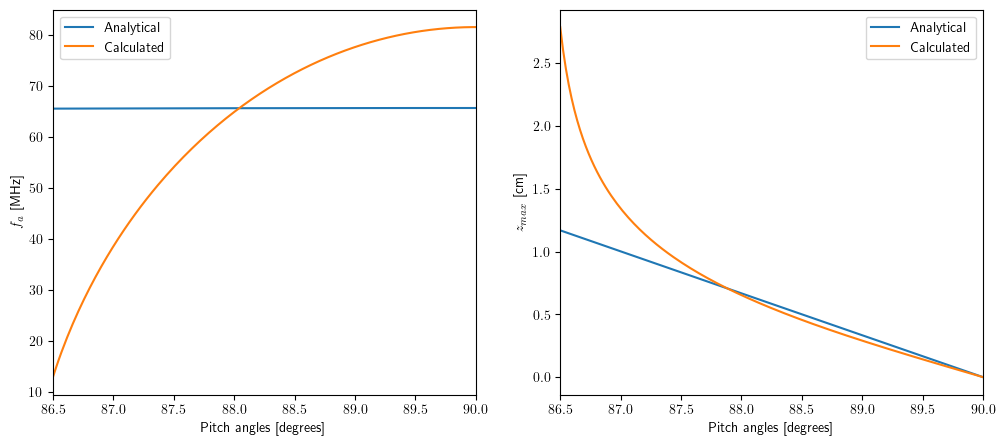

In [5]:
anaTrap = HarmonicTrap(B0_fit, L0_fit)
peArr = np.linspace(86.5, 89.999, 150) * np.pi / 180

axial_freqs_ana = anaTrap.CalcOmegaAxial(0.263 * sc.c, peArr) / (2 * np.pi)
zmax_ana = anaTrap.CalcZMax(peArr)
axial_freqs_calc = np.zeros_like(peArr)
zmax_calc = np.zeros_like(peArr)

for i, p in enumerate(peArr):
    zmax_calc[i] = calc_zmax(hField, Particle(18.6e3, np.zeros(3), p))
    axial_freqs_calc[i] = calc_omega_axial(hField, Particle(18.6e3, np.zeros(3), p))
    
axial_freqs_calc /= (2 * np.pi)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(peArr * 180 / np.pi, axial_freqs_ana / 1e6, label='Analytical')
ax[0].plot(peArr * 180 / np.pi, axial_freqs_calc / 1e6, label='Calculated')
ax[0].set_xlabel('Pitch angles [degrees]')
ax[0].set_ylabel(r'$f_a$ [MHz]')
ax[0].set_xlim(86.5, 90)
ax[0].legend()

ax[1].plot(peArr * 180 / np.pi, zmax_ana * 1e2, label='Analytical')
ax[1].plot(peArr * 180 / np.pi, zmax_calc * 1e2, label='Calculated')
ax[1].set_xlabel('Pitch angles [degrees]')
ax[1].set_ylabel(r'$z_{max}$ [cm]')
ax[1].set_xlim(86.5, 90)
ax[1].legend()

### Calculating $z(t)$

The axial position of the electron may be found as a function of time from
$$
t = \int_{z_0(0)}^{z_0(t)} \frac{dz'}{\sqrt{\frac{2}{m} (K_e - \mu B(z')) }} \, .
$$

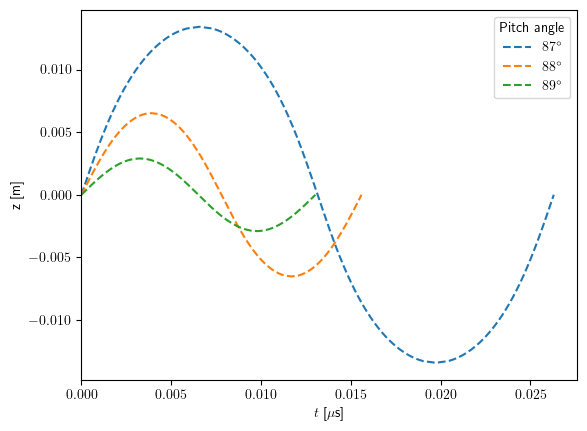

In [6]:
from CRESSignalStructure.NumericalSpectrumCalculator import calc_t_vs_z 

pitchAngle = 88.0 * np.pi / 180
t87, z87 = calc_t_vs_z(hField, Particle(18.6e3, np.zeros(3), 87 * np.pi / 180))
t88, z88 = calc_t_vs_z(hField, Particle(18.6e3, np.zeros(3), pitchAngle))
t89, z89 = calc_t_vs_z(hField, Particle(18.6e3, np.zeros(3), 89 * np.pi / 180))

plt.figure()
plt.plot(t87 * 1e6, z87, '--', label=r'$87^\circ$')
plt.plot(t88 * 1e6, z88, '--', label=r'$88^\circ$')
plt.plot(t89 * 1e6, z89, '--', label=r'$89^\circ$')
plt.xlabel(r"$t$ [$\mu$s]")
plt.ylabel(r"z [m]")
plt.legend(title='Pitch angle')
plt.xlim(0.0, None)
plt.show()

### Calculating $B(t)$

Using the previous result for the $z$ position, we can then calculating the experience magnetic field as a function of time.

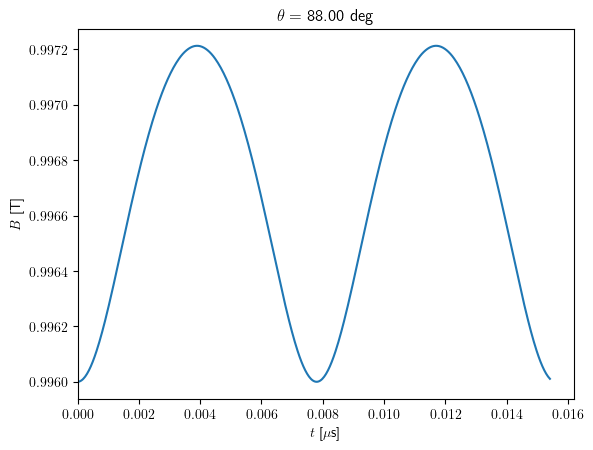

In [7]:
from CRESSignalStructure.NumericalSpectrumCalculator import B_from_t

pitchAngle = 88 * np.pi / 180
p1 = Particle(18.6e3, np.zeros(3), pitchAngle)

t, B = B_from_t(hField, p1, 499)
plt.figure()
plt.plot(t * 1e6, B)
plt.xlabel(r"$t$ [$\mu$s]")
plt.ylabel(r"$B$ [T]")
plt.title(fr"$\theta =$ {pitchAngle * 180 / np.pi:.2f} deg")
plt.xlim(0.0, None)
plt.show()

### Calculating $\Phi_c(t)$ and $\Omega_0$

Having calculating $B(t)$, we can then calculate the cyclotron phase as a function of time from
$$
\Phi_c(t) = \int_0^t \frac{e B(t')}{\gamma m_e} dt'
$$
which then allows us to calculate the average cyclotron frequency as
$$
\Omega_0 = \frac{\Phi_c(T_a)}{T_a} \, .
$$ 

Text(0, 0.5, '$\\Phi_c - \\Omega_0 t$ [radians]')

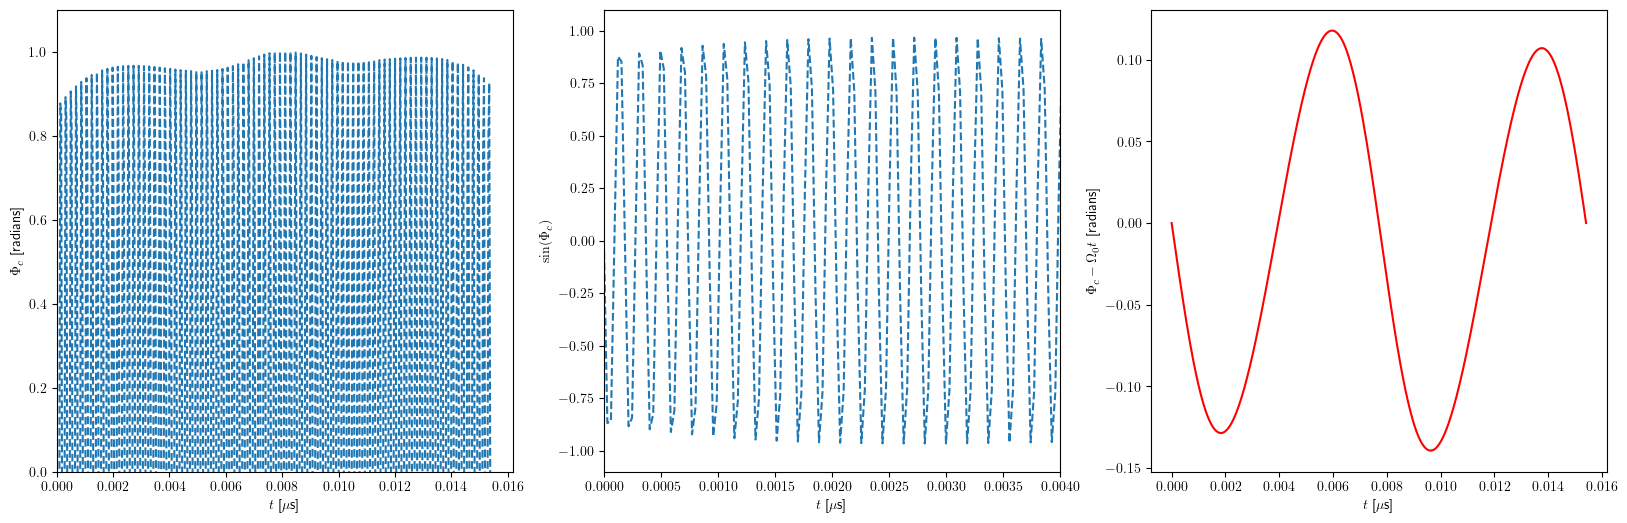

In [8]:
from CRESSignalStructure.NumericalSpectrumCalculator import cyclotron_phase_from_t, calc_omega_0

N_T_POINTS = 499

t, phiTest = cyclotron_phase_from_t(hField, p1, N_T_POINTS)
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].plot(t * 1e6, np.sin(phiTest), '--')
ax[0].set_xlabel(r"$t$ [$\mu$s]")
ax[0].set_ylabel(r"$\Phi_c$ [radians]")
ax[0].set_xlim(0, None)
ax[0].set_ylim(0, None)

ax[1].plot(t * 1e6, np.sin(phiTest), '--')
ax[1].set_xlabel(r"$t$ [$\mu$s]")
ax[1].set_ylabel(r"$\sin(\Phi_c)$")
ax[1].set_xlim(0, 0.004)

ax[2].plot(t * 1e6, phiTest - calc_omega_0(hField, p1, N_T_POINTS) * t, 'r-')
ax[2].set_xlabel(r"$t$ [$\mu$s]")
ax[2].set_ylabel(r"$\Phi_c - \Omega_0 t$ [radians]")

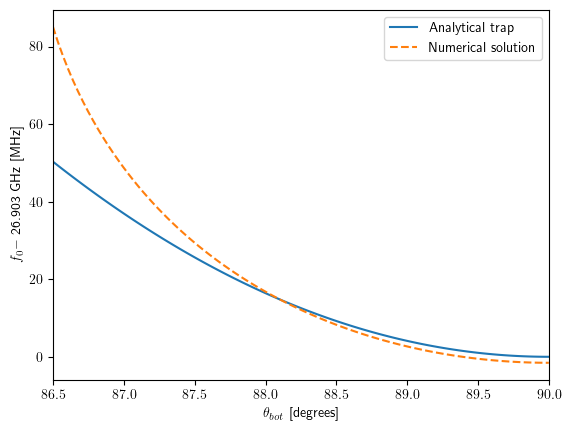

In [9]:
testNumericalPitches = np.linspace(86.5, 89.999, 100) * np.pi / 180
avgFreqsNumerical = np.zeros_like(testNumericalPitches)
for i, testPitch in enumerate(testNumericalPitches):
    testParticle = Particle(18.6e3, np.zeros(3), testPitch)
    # Calculate the axial frequency for the time binning
    oa = calc_omega_axial(hField, testParticle)
    avgFreqsNumerical[i] = calc_omega_0(hField, testParticle, N_T_POINTS) / (2 * np.pi)

avgFreqArray = anaTrap.CalcOmega0(Particle(18.6e3, np.zeros(3)).GetSpeed(), 
                                  testNumericalPitches) / (2 * np.pi)

plt.figure()
plt.plot(testNumericalPitches * 180 / np.pi, (avgFreqArray - np.min(avgFreqArray)) / 1e6, label='Analytical trap')
plt.plot(testNumericalPitches * 180 / np.pi, (avgFreqsNumerical - np.min(avgFreqArray)) / 1e6, 
         '--', label='Numerical solution')
plt.xlabel(r"$\theta_{bot}$ [degrees]")
plt.ylabel(fr"$f_0 -$ {np.min(avgFreqArray) / 1e9:.3f} GHz [MHz]")
plt.xlim(86.5, 90)
plt.legend()
plt.show()

## Fourier coefficients

Finally, the Fourier coefficients can be calculated via the equation
$$
a_n = \frac{1}{T_a} \int_0^{T_a} e^{i (\Phi_c(t) + k_\lambda z(t))} e^{-i (\Omega_0 + n\Omega_a)t} dt
$$

In [10]:
from CRESSignalStructure.PowerSpectrumCalculator import PowerSpectrumCalculator
from CRESSignalStructure.CircularWaveguide import CircularWaveguide

rWg = 5e-3  # 5mm radius waveguide
wg = CircularWaveguide(rWg)

pspecAna = PowerSpectrumCalculator(anaTrap, wg, p1)
n1 = pspecAna.GetPeakAmp(0)
print(n1)

-0.2046920817081697


In [11]:
from scipy.interpolate import interp1d
from scipy.integrate import simpson

def get_fourier_coeff(trap: BaseField, particle: Particle, n: int):
    """
    Calculate the Fourier coefficient for a given order 

    Parameters
    ----------
    trap : BathtubField
      Trapping field
    particle : Particle
      Particle to be propagated
    n : int
      Order of sideband

    Returns
    -------
    complex :
      Complex fourier coefficient
    """
    omega_a = calc_omega_axial(trap, particle)

    # Get z position at regularly spaced intervals
    t, z = calc_t_vs_z(trap, particle)
    interp_t_z = interp1d(t, z, kind='cubic')

    tVals, phi_t = cyclotron_phase_from_t(trap, particle, N_T_POINTS)
    Ta = tVals[-1]
    z_t = interp_t_z(tVals)
    omega_0 = calc_omega_0(trap, particle, N_T_POINTS)


    omega_c = 1.841 * sc.c / 5e-3
    v_phase = sc.c / np.sqrt(1 - (omega_c / omega_0)**2)
    kLambda = omega_0 / v_phase

    integrand = np.exp(1j * (phi_t + kLambda * z_t)) * np.exp(-1j * (omega_0 + n * omega_a) * tVals) 
    a_n = simpson(integrand, tVals)
    a_n /= Ta

    return a_n

In [12]:
print(get_fourier_coeff(hField, Particle(18.6e3, np.zeros(3), 89.999*np.pi/180.0), 0))

(0.999999639046509+4.7076103441781087e-07j)


Compare the analytic harmonic trap to the real deal

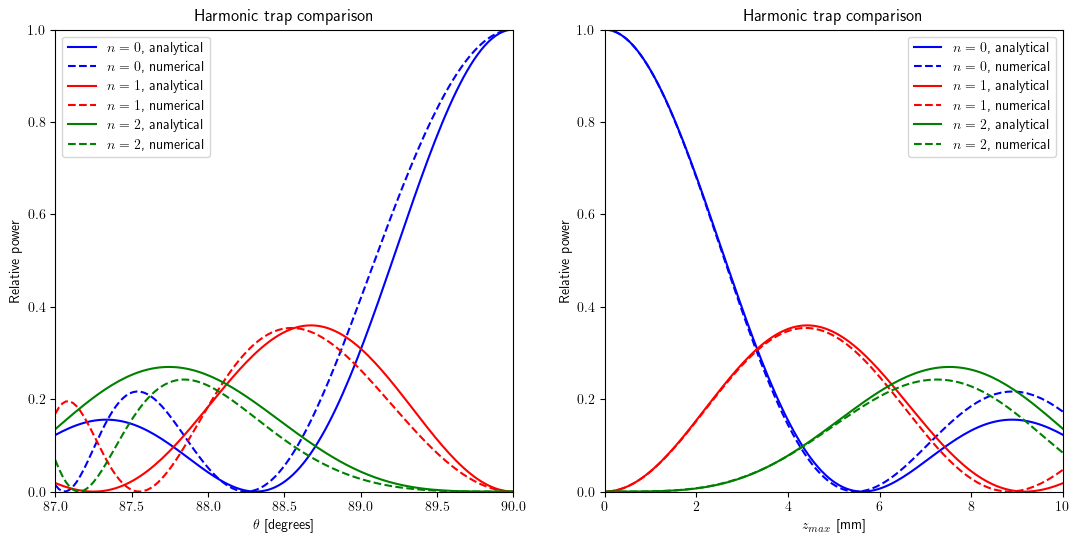

In [13]:
pitchAngleCoarse = np.linspace(87.0, 89.999, 130) * np.pi / 180
zmax_ana = np.zeros_like(pitchAngleCoarse)
zmax_num = np.zeros_like(pitchAngleCoarse)
a0_mainband_ana = np.zeros_like(pitchAngleCoarse, dtype=complex)
a0_mainband_num = np.zeros_like(pitchAngleCoarse, dtype=complex)
a1_mainband_ana = np.zeros_like(pitchAngleCoarse, dtype=complex)
a1_mainband_num = np.zeros_like(pitchAngleCoarse, dtype=complex)
a2_mainband_ana = np.zeros_like(pitchAngleCoarse, dtype=complex)
a2_mainband_num = np.zeros_like(pitchAngleCoarse, dtype=complex)

for i, p in enumerate(pitchAngleCoarse):
    thisParticle = Particle(18.6e3, np.zeros(3), p)
    zmax_ana[i] = anaTrap.CalcZMax(p)
    zmax_num[i] = calc_zmax(hField, thisParticle)

    a0_mainband_ana[i] = PowerSpectrumCalculator(anaTrap, wg, 
                                                 thisParticle).GetPeakAmp(0)
    a0_mainband_num[i] = get_fourier_coeff(hField, thisParticle, 0)
    a1_mainband_ana[i] = PowerSpectrumCalculator(anaTrap, wg, 
                                                 thisParticle).GetPeakAmp(1)
    a1_mainband_num[i] = get_fourier_coeff(hField, thisParticle, 1)
    a2_mainband_ana[i] = PowerSpectrumCalculator(anaTrap, wg, 
                                                 thisParticle).GetPeakAmp(2)
    a2_mainband_num[i] = get_fourier_coeff(hField, thisParticle, 2)

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
ax[0].plot(pitchAngleCoarse * 180 / np.pi, np.abs(a0_mainband_ana)**2, 'b-', 
        label=r'$n=0$, analytical')
ax[0].plot(pitchAngleCoarse * 180 / np.pi, np.abs(a0_mainband_num)**2, 'b--', 
        label=r'$n=0$, numerical')
ax[0].plot(pitchAngleCoarse * 180 / np.pi, np.abs(a1_mainband_ana)**2, 'r-', 
        label=r'$n=1$, analytical')
ax[0].plot(pitchAngleCoarse * 180 / np.pi, np.abs(a1_mainband_num)**2, 'r--', 
        label=r'$n=1$, numerical')
ax[0].plot(pitchAngleCoarse * 180 / np.pi, np.abs(a2_mainband_ana)**2, 'g-', 
        label=r'$n=2$, analytical')
ax[0].plot(pitchAngleCoarse * 180 / np.pi, np.abs(a2_mainband_num)**2, 'g--', 
        label=r'$n=2$, numerical')
ax[0].set_xlabel(r"$\theta$ [degrees]")
ax[0].set_ylabel("Relative power")
ax[0].set_title("Harmonic trap comparison")
ax[0].set_xlim(np.min(pitchAngleCoarse) * 180 / np.pi, 90.0)
ax[0].set_ylim(0, 1)
ax[0].legend()

ax[1].plot(zmax_ana * 1e3, np.abs(a0_mainband_ana)**2, 'b-', label=r'$n=0$, analytical')
ax[1].plot(zmax_num * 1e3, np.abs(a0_mainband_num)**2, 'b--', label=r'$n=0$, numerical')
ax[1].plot(zmax_ana * 1e3, np.abs(a1_mainband_ana)**2, 'r-', label=r'$n=1$, analytical')
ax[1].plot(zmax_num * 1e3, np.abs(a1_mainband_num)**2, 'r--', label=r'$n=1$, numerical')
ax[1].plot(zmax_ana * 1e3, np.abs(a2_mainband_ana)**2, 'g-', label=r'$n=2$, analytical')
ax[1].plot(zmax_num * 1e3, np.abs(a2_mainband_num)**2, 'g--', label=r'$n=2$, numerical')
ax[1].set_xlabel(r"$z_{max}$ [mm]")
ax[1].set_ylabel("Relative power")
ax[1].set_title("Harmonic trap comparison")
ax[1].set_xlim(0.0, 10.0)
ax[1].set_ylim(0, 1)
ax[1].legend()

Now use the new class to draw a fake FFT.

[-5 -4 -3 -2 -1  0  1  2  3  4  5]


Text(0.5, 1.0, '89.30 degrees')

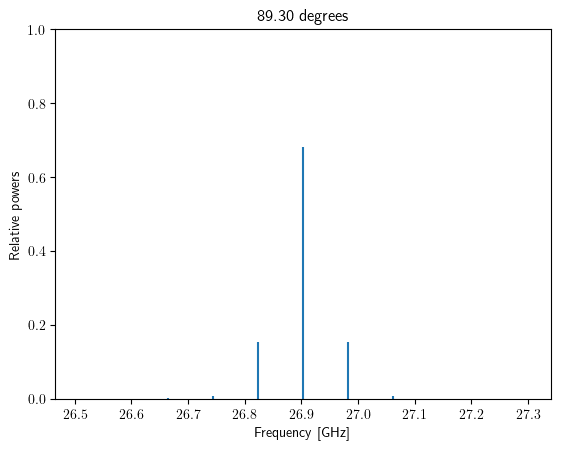

In [14]:
from CRESSignalStructure.NumericalSpectrumCalculator import NumericalSpectrumCalculator

p = Particle(18.6e3, np.zeros(3), 89.3 * np.pi / 180)
pspec = NumericalSpectrumCalculator(hField, wg, p)

N_MAX = 5
orders = np.arange(-N_MAX, N_MAX+1)
print(orders)
frequencies = pspec.GetPeakFrequency(orders)
relative_powers = np.abs(pspec.GetPeakAmp(orders))**2

fig, ax = plt.subplots(1, 1)
ax.vlines(frequencies / 1e9, np.zeros_like(frequencies), relative_powers)
ax.set_xlabel("Frequency [GHz]")
ax.set_ylabel("Relative powers")
ax.set_ylim(0, 1)
ax.set_title(f"{p.GetPitchAngle() * 180 / np.pi:.2f} degrees")